In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
pd.set_option('display.max_columns', 500)
%matplotlib inline

# Part 1: Test Error, CV

# 1. Getting the data

In [2]:
# read csv "fbr" into df. "fbr" stands for "footballer ratings"
df = pd.read_csv('fbr.csv')
display(df.head())

,age,height_cm,weight_kg,work_rate_att,overall
0,20,175,70,Medium,58
1,29,183,80,High,65
2,35,183,78,High,67
3,24,178,72,Medium,69
4,23,173,73,Medium,70


In [3]:
# For sklearn CV we need numerical data only --> use getdummies
# To reduce redundancy/co-linearity (i.e. same intercept), set drop_first=True
#df = pd.get_dummies(df, drop_first=False)
df = pd.get_dummies(df, drop_first=True)
display(df.head())

,age,height_cm,weight_kg,overall,work_rate_att_Low,work_rate_att_Medium
0,20,175,70,58,0,1
1,29,183,80,65,0,0
2,35,183,78,67,0,0
3,24,178,72,69,0,1
4,23,173,73,70,0,1


C:\Users\jacob\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='overall', ylabel='Density'>

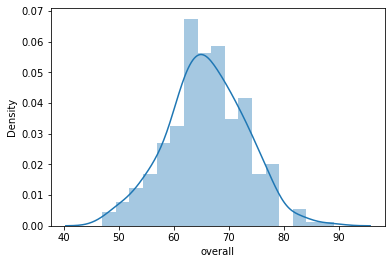

In [4]:
# How is our output ("overall") distributed?
sns.distplot(df.overall)

In [5]:
# Let's split our X and y data
X = df.iloc[:,[0,1,2,4,5]] #tedious
X = df.drop('overall', axis = 'columns')
y = df.overall

# Let's split into train/test data, test_size=0.2
# (random state=0 allows consistency across models)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0) 

## 2. Define loss, check test loss

In [6]:
# Define the train/test loss metric (MSE)
def mse(y,ypr):
    return np.mean((y-ypr)**2)

In [7]:
# Create a LinearRegression object, compute loss
lmodel = LinearRegression().fit(Xtrain,ytrain)
trloss = mse(ytrain,lmodel.predict(Xtrain))
teloss = mse(ytest,lmodel.predict(Xtest))
print(f"Training loss: {trloss}, Test loss: {teloss}")

Training loss: 33.23037858247384, Test loss: 40.952245375550405


## 3. Run 5-fold Cross-validation

In [8]:
# sklearn CV: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

# Before we apply it to our dataset, let's experiment with some CV examples

# Example 1: a 5-fold CV on a dataset
x=np.arange(20)
kf = KFold(n_splits=5)
print("5-fold CV")
for train,test in kf.split(x):
    print(f"{train}  {test}")

print("-"*63)

print("5-fold CV (shuffled)")
# Example 2: What if data not shuffled? 
kf2 = KFold(n_splits=5, shuffle=True)
for train,test in kf2.split(x):
    print(f"{train}  {test}")

print("-"*63)

# Example 3: n-fold Cross-Validation 
print("n-fold CV")
for train, test in LeaveOneOut().split(x):
    print(f"{train}  {test}")

5-fold CV
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]  [0 1 2 3]
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19]  [4 5 6 7]
[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19]  [ 8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19]  [12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]  [16 17 18 19]
---------------------------------------------------------------
5-fold CV (shuffled)
[ 0  2  3  5  6  7  9 10 11 12 14 15 16 17 18 19]  [ 1  4  8 13]
[ 1  2  3  4  5  8  9 10 11 12 13 14 16 17 18 19]  [ 0  6  7 15]
[ 0  1  3  4  6  7  8 10 11 12 13 15 16 17 18 19]  [ 2  5  9 14]
[ 0  1  2  3  4  5  6  7  8  9 12 13 14 15 16 18]  [10 11 17 19]
[ 0  1  2  4  5  6  7  8  9 10 11 13 14 15 17 19]  [ 3 12 16 18]
---------------------------------------------------------------
n-fold CV
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]  [0]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]  [1]
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]  [

In [9]:
# Ok, let's run CV on our dataset (use cross_val_score)
kf = KFold(n_splits=5, shuffle=False) #data already shuffled
sc = make_scorer(mse) #tell CV scorer how we want to eval test data
cvsc = cross_val_score(LinearRegression(), X, y, cv=kf, scoring=sc)

print(f"CV scores: {cvsc} | CV loss: {cvsc.mean()}")

CV scores: [24.02742989 35.5978666  35.92285439 46.5077554  36.25261759] | CV loss: 35.66170477264685


# Part 2: CV, Pipelines

## 4. Select the best model

In [10]:
 # Let's now use CV to pick from a few different models

# MODEL 1: LINEAR
M1 = LinearRegression().fit(Xtrain, ytrain)
M1trloss = mse(ytrain, M1.predict(Xtrain))
cvsc1 = cross_val_score(M1, Xtrain, ytrain, cv=kf, scoring=sc)

print(f"Training loss: {M1trloss} | CV loss: {cvsc1.mean()}")

Training loss: 33.23037858247384 | CV loss: 34.73847863572037


In [11]:
# MODEL 2: QUADRATIC (age only)

# we need to create age^2 column, then allocate training data
Xtrain2 = Xtrain.assign(age2 = Xtrain.age**2)
#Xtrain2 = Xtrain.assign(age2 = lambda x: x.age**2) #(alternative)
display(Xtrain2)

M2 = LinearRegression().fit(Xtrain2, ytrain)
M2trloss = mse(ytrain, M2.predict(Xtrain2))
cvsc2 = cross_val_score(M2, Xtrain2, ytrain, cv=kf, scoring=sc)

print(f"Training loss: {M2trloss} | CV loss: {cvsc2.mean()}")

,age,height_cm,weight_kg,work_rate_att_Low,work_rate_att_Medium,age2
250,24,188,79,0,1,576
312,28,175,76,0,0,784
341,27,186,73,0,0,729
284,19,181,75,1,0,361
21,18,172,70,0,1,324
...,...,...,...,...,...,...
323,26,188,85,0,0,676
192,19,175,68,0,1,361
117,20,185,72,0,1,400
47,22,181,72,0,1,484


Training loss: 30.500420414653426 | CV loss: 32.06606385474363


In [12]:
# MODEL 3: QUADRATIC (all features)

# instead of manually creating all squared columns, use PolynomialFeatures
Xtrain3 = PolynomialFeatures(degree=2, include_bias=False).fit_transform(Xtrain)
#print(Xtrain3.shape)

M3 = LinearRegression().fit(Xtrain3, ytrain)
M3trloss = mse(ytrain, M3.predict(Xtrain3))
cvsc3 = cross_val_score(M3, Xtrain3, ytrain, cv=kf, scoring=sc)

print(f"Training loss: {M3trloss} | CV loss: {cvsc3.mean()}")

Training loss: 29.35422283753904 | CV loss: 33.53150201012079


## 5. Less code needed (Pipelines)

In [13]:
# sklearn Pipelines (encapsulation of all modelling steps): https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

# define pipelines for each model
M1 = Pipeline([
    ('lr1', LinearRegression())
])

M3 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lr3', LinearRegression())
])

In [14]:
# What about M2? We'd need a custom transformer here. All custom transformers inherit from BaseEstimator and TransformerMixin

class Age2(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.assign(age2= X.age**2)
        return X

M2 = Pipeline([
    ('age_sqr', Age2()),
    ('lr2', LinearRegression())
])

In [15]:
# Let's check that our pipeline models are working

print(f"CV loss (M1): {cross_val_score(M1, Xtrain, ytrain, cv=kf, scoring=sc).mean()}")
print(f"CV loss (M2): {cross_val_score(M2, Xtrain, ytrain, cv=kf, scoring=sc).mean()}")
print(f"CV loss (M3): {cross_val_score(M3, Xtrain, ytrain, cv=kf, scoring=sc).mean()}")

CV loss (M1): 34.73847863572037
CV loss (M2): 32.06606385474363
CV loss (M3): 33.53150201012079


In [16]:
# Finally, let's get the test loss on the selected model (don't peek.. we could be underestimating if we looked at others)
telossFinal = mse(ytest, M2.fit(Xtrain, ytrain).predict(Xtest))
print(f"Test loss (M2): {telossFinal}")

Test loss (M2): 36.76170780965778
